# 

In [1]:
# unpack data
# !tar -xzvf JEOPARDY_QUESTIONS1.json.tar.gz

In [1]:
reset -fs

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, defaultdict

In [4]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
from jeopardy_funcs import *

## Load and Prep Data

# 0. Cleanup
Some cleanup/info
- [x] air-date to datetime
- [x] encode round
    - Daily Doubles are implicit from money value - Ignore
    - 3 Tiebreakers - Drop
- [ ] value to int/standardize money,  historical info [link](https://outsider.com/news/entertainment/jeopardy-show-double-dollar-values-categories/)
    - final question's have value np.nan
    - Rank question difficulty 1 through 11 (5 qn values 1st round, 5 qn values 2nd round, 1 final jeopardy)?
    - Or 1 through 13: 5 normal qn types plus daily double per round, times 2, and 1 final jeopardy
    - ~~for the pilot, questions values were 25-125 for first round, then doubled~~ pilot not in the data
    - Jeopardy! round was 100-500 for years
    - 11/26/01 doubled all monetary values, so 200-1000 for Jeopardy! round

In [7]:
# df['air_date']= pd.to_datetime(df['air_date'])
# df['year'] = df['air_date'].dt.year

# df = df[df['round']!='Tiebreaker']
df = prep_data(df)

---
# Q.1 Jeopardy Topics over Time

- (a) Annual Themes of questions asked during the three different rounds of the show
    - "Use LDA and/or NMF to identify topics of the questions asked during each portion, breaking up the documents according to year"
        - So as a first step, model over all years
        - Then change to model topics __per year__, and figure out topic comparisons

### Data Processing
- TFIDF to get the term-document matrix
- feed that into NMF or LDA 

In [8]:
W, H, df, vocab, tfidf_matrix = get_topics(df, 10, ret_tfidf=True)
df.head(5)

,category,air_date,question,value,answer,round,show_number,year,topic
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",200.0,Copernicus,Jeopardy!,4680,2004,6
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,200.0,Jim Thorpe,Jeopardy!,4680,2004,5
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,200.0,Arizona,Jeopardy!,4680,2004,7
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",200.0,McDonald\'s,Jeopardy!,4680,2004,5
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",200.0,John Adams,Jeopardy!,4680,2004,6


In [ ]:
d = get_topic_word_counts(df, vocab, tfidf_matrix, verbose=True)
# This takes forever to run, while code below (running locally)
# runs in 90 secs
# this cell gets to 20k in 90 secs :(

In [97]:
# replaced with fn above
# # tfidf_coo = scipy.sparse.coo_matrix(tfidf_matrix)
# start = time.time()
# d = defaultdict(Counter)

# checkpoints = [20_000 * _ for _ in range(tfidf_matrix.shape[0])]

# for i in range(tfidf_matrix.shape[0]):
#     _, cols = tfidf_matrix[i, :].nonzero()
#     if len(cols) == 0:
#         continue
#     d[df.loc[i].topic].update(set(vf(cols)))
#     #     print(set(vf(cols)))
#     if i in checkpoints
#         print(f'{i:,}, {time.time() - start}')

0.0016679763793945312
9.298269987106323
18.51532292366028
27.84427285194397
37.070990800857544
46.31890106201172
55.4399528503418
65.0339081287384
74.82665205001831
84.32529282569885
93.45832705497742


Maybe we need to clean up the questions first so we don't get weird words like these. One way could be to increase 'max_df' for the vectorizer.

- seting `min_df=3` drops 90k total to 41k words
    - `default=1` means `min_df=3` is a $\geq$
    - still has '00' etc in it

Text(0.5, 1.0, 'Histogram of Counts Per Topic')

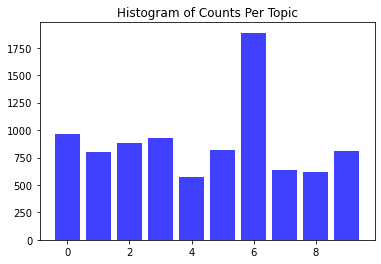

In [19]:
# for funsies - could make this a stacked histogram slowly changing color over time
plt.bar(range(W.shape[1]), np.sum(W, axis=0), alpha=.75, color='blue')
plt.title('Histogram of Counts Per Topic')

## Heatmaps of Questions in a Topic Per Year
Want to plot heatmap of counts per topic per year (large grid)

Have `H` and `samp` with index, go back and grab year 

In [21]:
# counts per year per topic
topic_year_cts = df.groupby(['year', 'topic'])['question'].count()

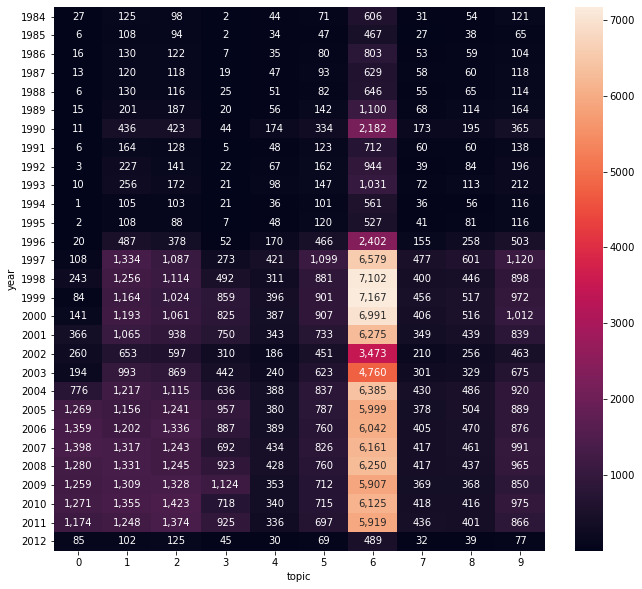

In [22]:
# z = np.array([[1,2],[3,4]])
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(topic_year_cts.unstack(), annot=True, fmt=',');

Normalize counts by year

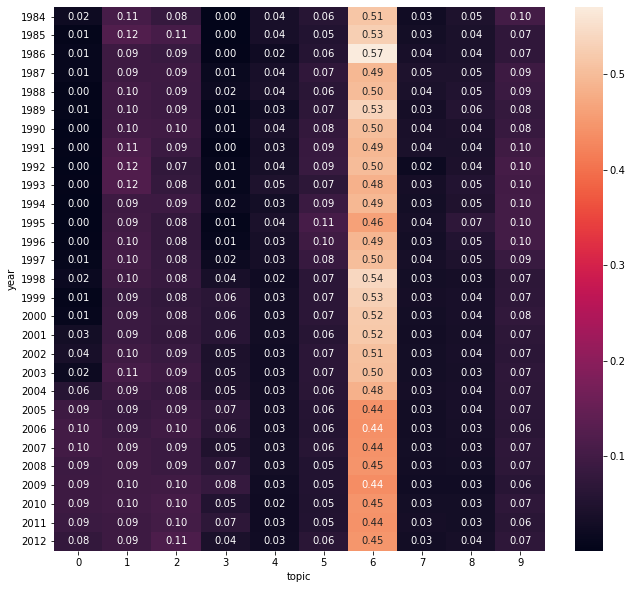

In [23]:
tpc_yr_df = topic_year_cts.unstack()
tpc_yr_normed = tpc_yr_df.div(tpc_yr_df.sum(axis=1), axis=0)

# z = np.array([[1,2],[3,4]])
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(tpc_yr_normed, annot=True, fmt=',.2f');

# Q.1 (a)(a) 

## Aside: Wordclouds
Looking to answer the question, what is this topic?

- Take H (Topic's proba, by Words idx), argmax gives each topic word is in

In [44]:
idx2word = {idx: word for word, idx in vocab.items()}

In [69]:
sorted_term_relevancy = np.argsort(-H, axis=1)

### Q1 continued
- Redo split by year